## Essencial Functions and Libraries

In [7]:
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

CLASSES_NAMES = {0:"Background",1:"Pinus",2:"Eucalyptus"}

def evaluate_f1_score(model, X_test, y_test, class_names=None, plot=True):
    # 1) obter predições
    if hasattr(model, "predict"):
        y_pred = model.predict(X_test)
    else:
        raise AttributeError("Model does not implement predict().")

    # 2) preparar nomes das classes
    classes = np.unique(y_test)
    if class_names is None:
        class_names = {cls: str(cls) for cls in classes}
    names = [class_names[cls] for cls in classes]

    # 3) calcular F1 para cada classe (one-vs-all)
    f1s = {}
    for cls in classes:
        y_true_bin = (y_test == cls).astype(int)
        y_pred_bin = (y_pred == cls).astype(int)
        f1 = f1_score(y_true_bin, y_pred_bin)
        f1s[class_names[cls]] = f1

    # 4) calcular F1‑macro
    macro_f1 = float(np.mean(list(f1s.values())))

    # 5) imprimir resultados
    for name, score in f1s.items():
        print(f"{name:<12} – F1 Score: {score:.4f}")
    print(f"\nMacro F1 Score: {macro_f1:.4f}")

    # 6) plot opcional
    if plot:
        fig, ax = plt.subplots(figsize=(6, 4))
        bars = ax.bar(f1s.keys(), f1s.values())

        # linha do F1‑macro
        ax.axhline(macro_f1, color='red', linestyle='--',
                   label=f"Macro F1 = {macro_f1:.2f}")

        # anotações
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, h,
                    f"{h:.2f}", ha='center', va='bottom')

        ax.set_ylim(0, 1.05)
        ax.set_ylabel("F1 Score")
        ax.set_title("F1 Score por Classe")
        ax.legend(loc='upper right')
        plt.xticks(rotation=15)
        plt.tight_layout()
        plt.show()

    return f1s, macro_f1

## Read data

In [8]:
# Spectral bands in the image:
# Blue  = X[:, 0]
# Green = X[:, 1]
# Red   = X[:, 2]
# NIR   = X[:, 3]

dataset_dir = 'spotlite_dataset_loca1_date1_dir1'

images_dataset_dir = os.path.join(dataset_dir, 'images')
masks_dataset_dir = os.path.join(dataset_dir, 'masks')

# Verify if directories exist (optional, but recommended)
assert os.path.exists(images_dataset_dir), f"Images directory not found: {images_dataset_dir}"
assert os.path.exists(masks_dataset_dir), f"Masks directory not found: {masks_dataset_dir}"

image_files = sorted(os.listdir(images_dataset_dir))
mask_files = sorted(os.listdir(masks_dataset_dir))

imgs, masks = [], []

# Check if the number of files match
assert len(image_files) == len(mask_files), "Number of images and masks don't match."

for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(images_dataset_dir, image_file)
    mask_path = os.path.join(masks_dataset_dir, mask_file)

    read_img = tiff.imread(image_path)
    read_mask = tiff.imread(mask_path)

    imgs.append(read_img)
    masks.append(read_mask)

imgs = np.stack(imgs)   # (N, H, W, C)
masks = np.stack(masks) # (N, H, W)

print(f'shape of imgs: {imgs.shape}')
print(f'shape of masks: {masks.shape}')

shape of imgs: (191, 512, 512, 4)
shape of masks: (191, 512, 512)


## Convert labels in masks

In [9]:
# Convert labels in masks from 0, 3, 4 to 0, 1, 2
# where 0 is background, 1 is class 1, and 2 is class
def remap_mask(mask):
    if not torch.is_tensor(mask):
        mask = torch.from_numpy(mask)
    remapped = torch.zeros_like(mask)
    remapped[mask == 0] = 0
    remapped[mask == 3] = 1
    remapped[mask == 4] = 2
    return remapped.long()

masks = remap_mask(masks)

print(f'shape of remapped masks: {masks.shape}')

shape of remapped masks: torch.Size([191, 512, 512])


## Extract features and labels

In [10]:
N, H, W, C = imgs.shape
X = imgs.reshape(-1, C)       # shape = (N*H*W, 4)
y = masks.reshape(-1)         # shape = (N*H*W,)

print(f'shape of X: {X.shape}')
print(f'shape of y: {y.shape}')

# (Opcional) amostragem para acelerar treino
# idx = np.random.choice(len(y), size=100000, replace=False)
# X, y = X[idx], y[idx]

shape of X: (50069504, 4)
shape of y: torch.Size([50069504])


## Check Inbalance

Classe 0: 48,043,641 pixels (95.95%)
Classe 1: 687,567 pixels (1.37%)
Classe 2: 1,338,296 pixels (2.67%)
   class    counts    percent
0      0  48043641  95.953898
1      1    687567   1.373225
2      2   1338296   2.672876


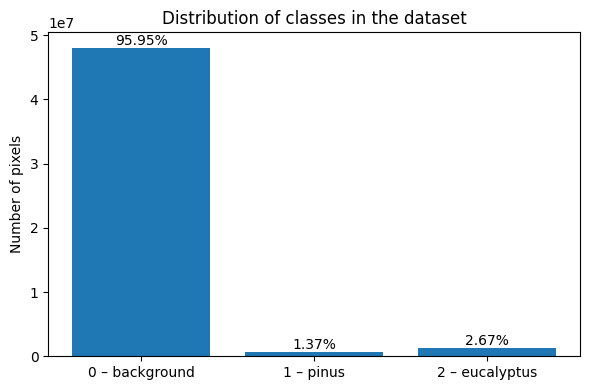

In [11]:
y = np.array(y)

y_flat = y.reshape(-1)
total_pixels = y_flat.size
classes, counts = np.unique(y_flat, return_counts=True)

for cls, ct in zip(classes, counts):
    pct = ct / total_pixels * 100
    print(f"Classe {cls}: {ct:,} pixels ({pct:.2f}%)")

df_dist = pd.DataFrame({
    "class":   classes,
    "counts":  counts,
    "percent": counts / total_pixels * 100
})
print(df_dist)

class_names = {
    0: "background",
    1: "pinus",
    2: "eucalyptus"
}
x_labels = [f"{cls} – {class_names[cls]}" for cls in df_dist['class']]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(df_dist['class'], df_dist['counts'])

ax.set_ylabel('Number of pixels')
ax.set_title('Distribution of classes in the dataset')

ax.set_xticks(df_dist['class'])
ax.set_xticklabels(x_labels)

for bar, pct in zip(bars, df_dist['percent']):
    x  = bar.get_x() + bar.get_width()/2
    y  = bar.get_height()
    ax.text(x, y, f"{pct:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Split training/testing

In [12]:
# Ensure y is the correct array-like object
y = masks.reshape(-1)  # Restore y to its original form
y = np.array(y)
X = np.array(X, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of X_train: (37552128, 4)
shape of y_train: (37552128,)
shape of X_test: (12517376, 4)
shape of y_test: (12517376,)


### Train Random Forest 

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ja testei aqui com otimização de hiperparâmetros baysiana, mas deu o mesmo resultado com essa forma simples

rf = RandomForestClassifier(
    n_estimators=20,    # poucas árvores
    max_depth=15,       # limita a complexidade
    n_jobs=-1,
    random_state=42
)

# 3) Treine
rf.fit(X_train, y_train)

# 4) Preveja e avalie
y_pred = rf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9694    0.9943    0.9816  12010910
           1     0.2727    0.0000    0.0000    171892
           2     0.6397    0.3786    0.4757    334574

    accuracy                         0.9641  12517376
   macro avg     0.6273    0.4576    0.4858  12517376
weighted avg     0.9510    0.9641    0.9546  12517376

=== Confusion Matrix ===
[[11941884        5    69021]
 [  169562        3     2327]
 [  207892        3   126679]]


#### Metric - F1 score

Background   – F1 Score: 0.9816
Pinus        – F1 Score: 0.0000
Eucalyptus   – F1 Score: 0.4757

Macro F1 Score: 0.4858


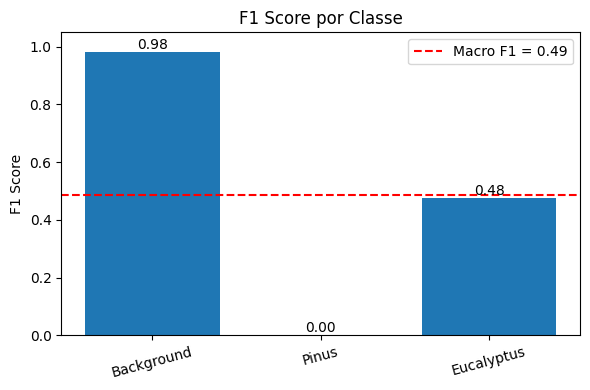

In [15]:
f1s_rf, macro_f1_rf = evaluate_f1_score(rf, X_test, y_test, class_names=CLASSES_NAMES, plot=True)

### Train SVM

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1) Take a stratified subset to train faster
sample_size = 200_000
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train,
    train_size=sample_size,
    stratify=y_train,
    random_state=42
)
print(f"shape of X_sub: {X_sub.shape}, y_sub: {y_sub.shape}")

# 2) Build the “fast SVM” pipeline
fast_svm = make_pipeline(
    StandardScaler(),  
    RBFSampler(gamma=0.1, n_components=500, random_state=42),
    SGDClassifier(
        loss='hinge',            
        max_iter=5,             
        tol=1e-3,
        random_state=42
    )
)

# 3) Train on the subset
fast_svm.fit(X_sub, y_sub)

# 4) Predict on the full test set
y_pred = fast_svm.predict(X_test)

# 5) Evaluate
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


shape of X_sub: (200000, 4), y_sub: (200000,)


/home/wilgo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


=== Classification Report ===


/home/wilgo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wilgo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wilgo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

              precision    recall  f1-score   support

           0     0.9595    1.0000    0.9794  12010910
           1     0.0000    0.0000    0.0000    171892
           2     0.0000    0.0000    0.0000    334574

    accuracy                         0.9595  12517376
   macro avg     0.3198    0.3333    0.3265  12517376
weighted avg     0.9207    0.9595    0.9397  12517376

=== Confusion Matrix ===
[[12010910        0        0]
 [  171892        0        0]
 [  334574        0        0]]


#### Metric - F1 score

Background   – F1 Score: 0.9794
Pinus        – F1 Score: 0.0000
Eucalyptus   – F1 Score: 0.0000

Macro F1 Score: 0.3265


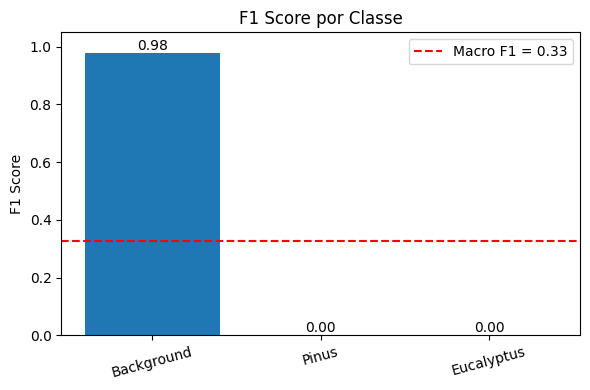

In [17]:
f1s_svm, macro_f1_svm = evaluate_f1_score(fast_svm, X_test, y_test, class_names=CLASSES_NAMES, plot=True)


### Train Neural Network (MLP)

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

nn_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(50,),      # 1 hidden layer with 50 neurons
        activation='relu',             # ReLU activation
        solver='adam',                 # Adam optimizer
        alpha=1e-4,                    # L2 regularization
        batch_size=256,                # Mini-batch size
        max_iter=100,                  # Maximum of 100 epochs
        early_stopping=True,           # Stops automatically if no improvement
        validation_fraction=0.1,       # 10% of data for internal validation
        n_iter_no_change=10,           # Patience of 10 epochs
        random_state=42,
        verbose=True
    ))
])

X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train,
    train_size=200_000,      # adjust based on your hardware
    stratify=y_train,
    random_state=42
)
nn_pipeline.fit(X_sub, y_sub)

# 4) Evaluation on the full test set
y_pred_nn = nn_pipeline.predict(X_test)

print("=== Classification Report (MLP) ===")
print(classification_report(y_test, y_pred_nn, digits=4))

print("=== Confusion Matrix (MLP) ===")
print(confusion_matrix(y_test, y_pred_nn))


Iteration 1, loss = 0.24499340
Validation score: 0.958300
Iteration 2, loss = 0.14193798
Validation score: 0.958250
Iteration 3, loss = 0.13343041
Validation score: 0.958250
Iteration 4, loss = 0.12885502
Validation score: 0.959150
Iteration 5, loss = 0.12568403
Validation score: 0.959600
Iteration 6, loss = 0.12343733
Validation score: 0.960200
Iteration 7, loss = 0.12183604
Validation score: 0.960700
Iteration 8, loss = 0.12065808
Validation score: 0.961200
Iteration 9, loss = 0.11983762
Validation score: 0.961050
Iteration 10, loss = 0.11919636
Validation score: 0.961350
Iteration 11, loss = 0.11862498
Validation score: 0.961600
Iteration 12, loss = 0.11820937
Validation score: 0.961850
Iteration 13, loss = 0.11790698
Validation score: 0.961400
Iteration 14, loss = 0.11755186
Validation score: 0.961900
Iteration 15, loss = 0.11728842
Validation score: 0.961550
Iteration 16, loss = 0.11703693
Validation score: 0.961800
Iteration 17, loss = 0.11680276
Validation score: 0.961850
Iterat

/home/wilgo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wilgo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wilgo/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

              precision    recall  f1-score   support

           0     0.9699    0.9929    0.9812  12010910
           1     0.0000    0.0000    0.0000    171892
           2     0.6025    0.3983    0.4796    334574

    accuracy                         0.9634  12517376
   macro avg     0.5241    0.4637    0.4869  12517376
weighted avg     0.9467    0.9634    0.9544  12517376

=== Confusion Matrix (MLP) ===
[[11925644        0    85266]
 [  169227        0     2665]
 [  201304        0   133270]]


#### Metric - F1 score

Background   – Average Precision: 0.9958
Pinus        – Average Precision: 0.0676
Eucalyptus   – Average Precision: 0.5280

Mean Average Precision (mAP): 0.5305


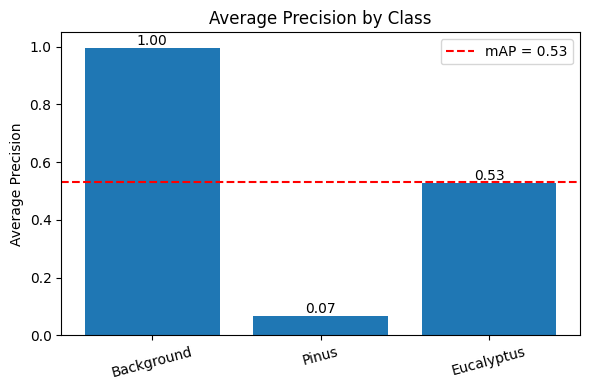

In [ ]:
f1s_mlp, macro_f1_mlp = evaluate_f1_score(nn_pipeline, X_test, y_test, class_names=CLASSES_NAMES, plot=True)

## Compare Models

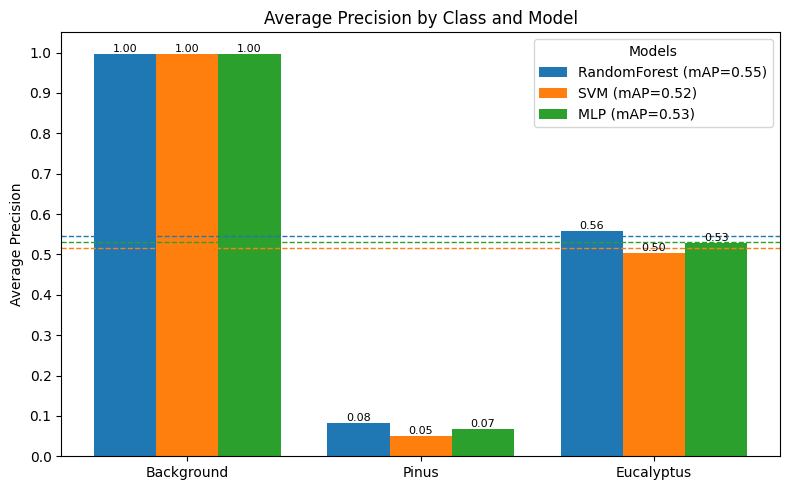

In [17]:
results = {
    "RandomForest": (aps_clf, map_clf),
    "SVM":          (aps_svm, map_svm),
    "MLP":          (aps_mlp, map_mlp),
}

# build DataFrame of per‐class APs
df_aps = pd.DataFrame(
    { model: aps for model, (aps, _m) in results.items() },
    index=[CLASSES_NAMES[k] for k in sorted(CLASSES_NAMES)]
)

# plot grouped bars with horizontal mean lines
fig, ax = plt.subplots(figsize=(8,5))
models   = df_aps.columns
n_models = len(models)
indices  = np.arange(len(df_aps))
bar_w    = 0.8 / n_models

for i, model in enumerate(models):
    mAP  = results[model][1]
    bars = ax.bar(
        indices + i*bar_w,
        df_aps[model],
        width=bar_w,
        label=f"{model} (mAP={mAP:.2f})"
    )
    # annotate each bar, centered horizontally
    for bar in bars:
        x = bar.get_x() + bar.get_width()/2
        y = bar.get_height()
        ax.text(x, y, f"{y:.2f}",
                ha='center', va='bottom', fontsize=8)
    # add horizontal line at the model's mAP, in same color
    color = bars[0].get_facecolor()
    ax.axhline(y=mAP, color=color, linestyle='--', linewidth=1)

# center x‐tick labels under groups
ax.set_xticks(indices + bar_w*(n_models-1)/2)
ax.set_xticklabels(df_aps.index)

# set y‐axis ticks from 0.0 to 1.0 in steps of 0.1
ax.set_yticks(np.arange(0, 1.05, 0.1))

ax.set_ylabel("Average Precision")
ax.set_ylim(0, 1.05)
ax.set_title("Average Precision by Class and Model")
ax.legend(title="Models", loc='upper right')
plt.tight_layout()
plt.show()


## Tips to improve if the results are not goods

Levers you can explore to further enhance the quality of segmentation:

Suggested short-term steps:

1. **Incorporate indices and textures**: expand your feature vector and re-evaluate with RF and SVM.
2. **GridSearchCV**: define reasonable ranges and search for the best parameters.
3. **Pipeline with CRF**: apply spatial refinement to RF/SVM outputs.
4. **Learning Curves**: ensure you're not saturated (overfitting) or underfitted.

Following these paths, you should gain robustness, precision, and generalization in the semantic segmentation of pine and eucalyptus!

1. Feature Engineering

* **Spectral Indices**
  In addition to raw bands, calculate indices like NDVI, NDWI, SAVI, EVI… each highlights specific vegetation and soil characteristics.

* **Texture and Local Statistics**
  Use GLCM (contrast, homogeneity, entropy), Gabor filters, LBP (Local Binary Patterns), or statistics (mean, variance) in windows (3×3, 5×5) to incorporate spatial context into your feature vectors.

* **Morphological Profiles**
  Extract signatures based on morphological openings and closings to capture the shape and size of tree canopies.

2. Modeling and Hyperparameter Tuning

* **Hyperparameter Search**

  * `GridSearchCV` or `RandomizedSearchCV` (scikit-learn) for RF (`n_estimators`, `max_depth`), SVM (`C`, `gamma`, `kernel`), and MLP (`hidden_layer_sizes`, `alpha`).
  * Bayesian optimization tools (Optuna, Hyperopt) can be more efficient in large spaces.

* **Stratified Cross-Validation**
  Use `StratifiedKFold` to ensure each fold respects class proportions and avoids overfitting on majority pixels.

* **Ensembles and Stacking**
  Combine RF, SVM, and MLP in an ensemble via VotingClassifier or create a meta-model (stacking) that learns to weight the outputs of each classifier.

3. Spatial Context and Post-Processing

* **Neighborhood Window**
  Instead of classifying isolated pixels, feed models with vectors extracted from a “patch” (e.g., vector of size 5×5×4 bands found in 100 features).

* **Superpixels + Classification**
  Generate superpixels (SLIC, Felzenszwalb), extract features by region, and classify entire regions to reduce noise.

* **Refinement with CRF / MRF**
  Apply a Conditional Random Field (e.g., `pydensecrf`) or Graph Cuts over the raw prediction map to enforce spatial coherence and smooth isolated jumps.

* **Morphological Operations**
  Apply “opening” and “closing” on the binary map of each class to remove small spurious regions and close gaps.

4. Data Augmentation and Generalization

* **Data Augmentation**

  * Rotate, flip, scale, and add noise to your images to make the classifier more robust to variations in orientation and lighting.
  * For each training patch, generate randomly transformed versions.

* **Light Transfer Learning**
  Even without powerful GPUs, you can use a pre-trained backbone (e.g., ResNet16) only as a feature extractor, combining it with a traditional classifier (RF or SVM) on the extracted features.

5. Metrics and Monitoring

* **Learning Curve**
  Plot error/accuracy as a function of training size to see if you're “data-limited” or “more data won't help.”

* **ROC Curves and AUC per Class**
  Measure sensitivity/specificity individually for pine and eucalyptus.

* **Error Analysis**
  Manually inspect misclassified regions to understand if they are shadows, planting edges, or class mixtures, and create features to mitigate these cases.

6. Migration to Deep Learning (If possible)

* **U-Net / DeepLab**
  Lightweight architectures (ENet, Fast-SCNN) can be trained even on modest GPUs and often outperform purely classical approaches in segmentation.

* **Patch-Wise Training**
  Train your network on overlapping patches (e.g., 128×128) with on-the-fly *data augmentation* to make better use of the data.






## Include Extra Channel (NDVI)

## Data augmentation

## Later Fusion

when a single model doesn’t achieve the desired performance, a late fusion (ensemble) of several classifiers almost always improves both robustness and accuracy. Here are the main approaches:

1. Voting (“Hard” or “Soft” Voting)
Hard Voting: each model casts a vote for its predicted class; the class with the most votes wins.

Soft Voting: each model provides probabilities (predict_proba); you sum (or average) them and pick the class with the highest average probability.


Example with scikit‑learn
python
Copy
Edit
from sklearn.ensemble import VotingClassifier

assuming you already have rf, svm and nn_pipeline trained
voting_clf = VotingClassifier(
    estimators=[
        ('rf',  rf),
        ('svm', svm),
        ('mlp', nn_pipeline)
    ],
    voting='soft',           # use 'hard' if models don’t support predict_proba
    weights=[2,1,1],         # optional: give more weight to RF, for example
    n_jobs=-1
)

train (fits all models internally)
voting_clf.fit(X_train, y_train)

evaluate
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred))


2. Stacking
Instead of voting, you use the base models’ predictions (“meta‑features”) to train a meta‑model (e.g. a small RF or logistic regression) that learns the best way to combine them.

Quick example
python
Copy
Edit
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_clf = StackingClassifier(
    estimators=[
        ('rf',  rf),
        ('svm', svm),
        ('mlp', nn_pipeline)
    ],
    final_estimator=LogisticRegression(
        class_weight='balanced', max_iter=200
    ),
    cv=5,           folds used to generate meta‑training predictions
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)
print(classification_report(y_test, y_pred_stack))


3. Blending
Similar to stacking, but the base‑model predictions are “blended” on a held‑out validation set to train the meta‑model, requiring fewer CV folds.

4. Points to Consider
Heterogeneity: combine models of different types (RF + SVM + MLP) to maximize gains.

Weights: in soft voting, adjust weights according to each model’s performance.

Meta‑features: in addition to predicted probabilities, you can include confidence metrics, probability‑vector entropy, etc.

Validation: always perform an external cross‑validation (e.g. cross_val_score on the entire ensemble) to avoid overfitting in stacking.

Conclusion
If your individual classifiers still fall short, late fusion via voting or stacking is definitely recommended. You’ll typically see improvements both in per‑class average precision and in overall mean average precision.

## Deep Models